# Trufl
> Optimizing adaptive sampling using Multiple-criteria decision-making

**Trufl** was initiated in the context of the [IAEA (International Atomic Energy Agency)](https://www.iaea.org) Coordinated Research Project titled ["Monitoring and Predicting Radionuclide Uptake and Dynamics for Optimizing Remediation of Radioactive Contamination in Agriculture"](https://www.iaea.org/newscenter/news/new-crp-monitoring-and-predicting-radionuclide-uptake-and-dynamics-for-optimizing-remediation-of-radioactive-contamination-in-agriculture-crp-d15019).

While **Trufl** was originally developed to address the remediation of farmland affected by nuclear accidents, its approach and algorithms are **applicable to a wide range of application domains**. This includes managing **legacy contaminants or monitoring any phenomenon that requires consideration of multiple decision criteria**, potentially involving a large set of data.

This package leverages the work done by [Floris Abrams](https://www.linkedin.com/in/floris-abrams-59080a15a) in the context of his PhD at [KU Leuven](https://www.kuleuven.be) and [Franck Albinet](https://www.linkedin.com/in/franckalbinet), International Consultant in Geospatial Data Science and currently PhD researcher in AI applied to nuclear remedation at KU Leuven.


## Install

`pip install trufl`

## Getting started

In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.collector import DataCollector
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

red, black = '#BF360C', '#263238'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a vector grid from a given raster

In [ ]:
fname_raster = './files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [ ]:
gdf_grid.head()

,geometry
loc_id,
0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


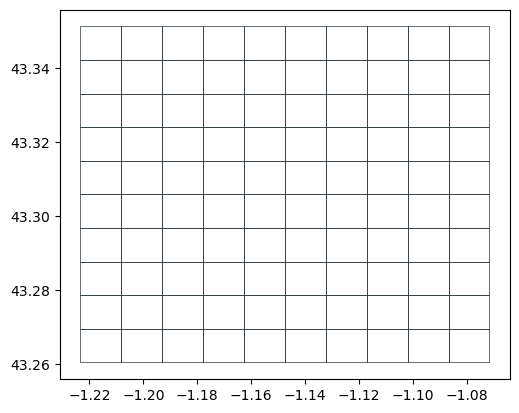

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5);

### Random sampling in areas of interest

Generating a random set of points within a given:
- a geodataframe of polygons of interest (in this example just a grid with `loc_id`s);
- For each subarea (`loc_id`), we specify the number of measurements to be taken, which we simulate here by generating random numbers.

                                                 geometry
loc_id                                                   
0       MULTIPOINT ((-1.22182 43.26138), (-1.22158 43....
1       MULTIPOINT ((-1.21672 43.27361), (-1.21541 43....
2                               POINT (-1.21801 43.27919)
3       MULTIPOINT ((-1.22264 43.29411), (-1.22207 43....
4       MULTIPOINT ((-1.21371 43.29700), (-1.21006 43....


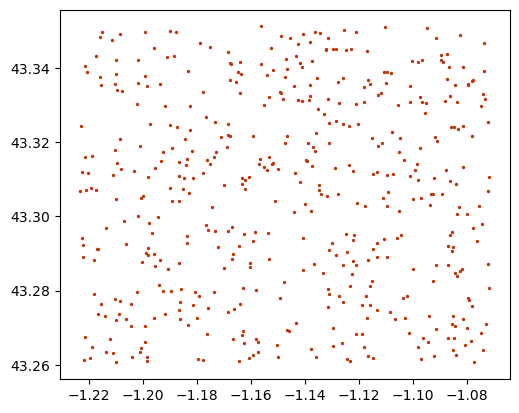

In [ ]:
sampler = Sampler(gdf_grid)
n = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
sample_locs = sampler.sample(n, method='uniform')

print(sample_locs.head())
sample_locs.plot(markersize=2, color=red);

### Emulating data collection

With random sampling location defined, data collector should be to the field to take measurements. In our case, we "emulate" this process by "extracting" measurements from provided raster file.

We will emulate data collection from the raster shown below:

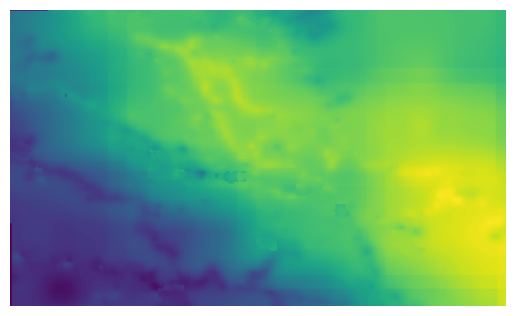

In [ ]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

"Measuring" variable of interest from a given raster:

                         geometry     value
loc_id                                     
0       POINT (-1.22182 43.26138)  0.137890
0       POINT (-1.22158 43.26741)  0.124069
0       POINT (-1.21942 43.26181)  0.141608
0       POINT (-1.21880 43.26477)  0.145231
0       POINT (-1.21376 43.26352)  0.104063


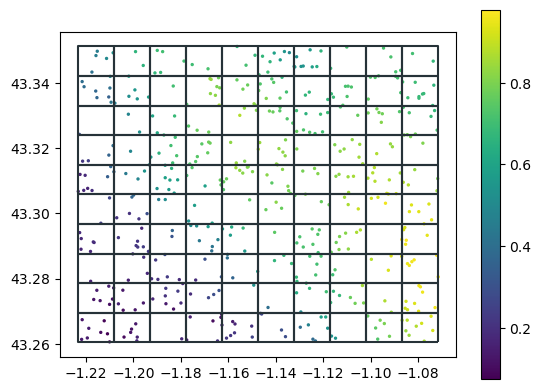

In [ ]:
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs)

print(samples_t0.head())
ax = samples_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [ ]:
state = State(samples_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)
])

# You have to call the instance
state_t0 = state(); state_t0

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.145231,0.074017,0.025631,8,0.915078,0.102492
1,0.152964,0.111763,0.015033,7,0.679907,0.125727
2,0.160229,0.160229,0.000000,1,NaN,0.161802
3,0.188177,0.164264,0.008248,6,0.940746,0.184432
4,0.261005,0.241690,0.009657,2,NaN,0.201405
...,...,...,...,...,...,...
95,0.877876,0.800729,0.027397,5,NaN,0.803670
96,0.804376,0.795942,0.004217,2,NaN,0.763408
97,0.799064,0.672111,0.047581,8,0.948441,0.727797


## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5) -- Gives 2 values (value , p-value)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit

### MCDM techniques
- CP -- low values -- good alternative
- TOPSIS -- High Value -- good alternative

! Everything is converted to rank to account for these differences ! 


In [ ]:
benefit_criteria = [True, True, True]
state = State(samples_t0, gdf_grid, cbs=[MaxCB(), MinCB(), StdCB()])

In [ ]:
optimizer = Optimizer(state=state())
df = optimizer.rank(is_benefit_x=benefit_criteria, w_vector = [0.3, 0.3, 0.4],  
                    n_method=None, c_method = None, w_method=None, s_method="CP")

df.head()

,rank
loc_id,
93,1
92,2
84,3
91,4
83,5


In [ ]:
# https://kapernikov.com/ipywidgets-with-matplotlib/